## Medical Appointment No Shows

# **Introduction**

An analysis of the medical appointment no-show dataset.
 
Column definition (described from author):

* PatientId - Identification of a patient
* AppointmentID - Identification of each appointment
* Gender = Male or Female
* ScheduledDay = The day of the actual appointment
* AppointmentDay = The day someone called or registered the appointment
* Age = Age of the patient
* Neighbourhood = Where the appointment takes place.
* Scholarship = If the person receives welfare assistance (True of False)
* Hipertension = True or False
* Diabetes = True or False
* Alcoholism = True or False
* Handicap = True or False
* SMS_received = 1 or more messages sent to the patient.
* No-show = True or False.

### 1. Load Libraries

Below we will load all the required libraries. Libraries for reading CSV File, Basic EDA, Visualization and Data Modeling are all loaded in the below cell.

In [ ]:
import pandas as pd
import numpy as np
import datetime
from time import strftime

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [ ]:
week_key = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

### 2. Load Data

In the below cell we will load the data from the CSV file in to a DataFrame. We will also check the row and column count by getting the shape of the data.

In [ ]:
df = pd.read_csv('../input/noshowappointments/KaggleV2-May-2016.csv')

In [ ]:
print("The shape of the DataFrame is => {}".format(df.shape))

### 3. Basic Info of the Data

In the below cells we will see the basic information about the data that we had loaded in the previous step.

In [ ]:
df.info()

As can be seen above there are no NaN values in any of the columns.

In [ ]:
# Print the top 5 rows
df.head()

### 4. Correct Incosistencies in Data

Below we will correct some of the inconsistencies in the data:

1. PatientId is an Integer and not Float. So, we will convert it into int64.
2. Data Type of ScheduledDay and AppointmentDay will be changed to DateTime.
3. Typo's in the Column names will be corrected
4. As the AppointmentDay has 00:00:00 in it's TimeStamp, we will ignore it.
5. As we removed the Time from AppointmentDay's TimeStamp we will do a similar thing for ScheduledDay also. (Ideally the Time in AppointmentDay column will help us better rather than in the ScheduledDay)

In [ ]:
# Convert PatientId from Float to Integer
df['PatientId'] = df['PatientId'].astype('int64')

# Convert ScheduledDay and AppointmentDay from 'object' type to 'datetime64[ns]'
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay']).dt.date.astype('datetime64[ns]')
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay']).dt.date.astype('datetime64[ns]')

# Rename incorrect column names.
df = df.rename(columns={'Hipertension': 'Hypertension', 'Handcap': 'Handicap', 'SMS_received': 'SMSReceived', 'No-show': 'NoShow'})

In [ ]:
df.info()

In [ ]:
df.head()

### 5. Data Wrangling, Feature Engineering and EDA

In [ ]:
print("Features in the DataFrame => {}".format(df.columns.ravel()))

From the above Info of the DataFrame and the sample data we can see that there are 14 columns in total.

 - There are 13 Independent Variables -> ['PatientId' 'AppointmentID' 'Gender' 'ScheduledDay' 'AppointmentDay' 'Age' 'Neighbourhood' 'Scholarship' 'Hypertension' 'Diabetes' 'Alcoholism' 'Handicap' 'SMSReceived']
 - The Dependent Variable is -> ['NoShow']

Below, we will drop 'PatientId' and 'AppointmentID' from the dataframe as they are just some system genrated numbers and shouldn't be used for predicting the dependent variable.

In [ ]:
# Drop 'PatientId' and 'AppointmentID' as they are just some system genrated numbers.
df.drop(['PatientId', 'AppointmentID'], axis=1, inplace=True)

In [ ]:
# Print Unique Values
print("Unique Values in `Gender` => {}".format(df.Gender.unique()))
print("Unique Values in `Scholarship` => {}".format(df.Scholarship.unique()))
print("Unique Values in `Hypertension` => {}".format(df.Hypertension.unique()))
print("Unique Values in `Diabetes` => {}".format(df.Diabetes.unique()))
print("Unique Values in `Alcoholism` => {}".format(df.Alcoholism.unique()))
print("Unique Values in `Handicap` => {}".format(df.Handicap.unique()))
print("Unique Values in `SMSReceived` => {}".format(df.SMSReceived.unique()))

From the above detail we can see that except for `Handicap` which has four values and `Gender` which has 'M' and 'F' all the other features have 'Yes' or 'No' kind of values. So, we will convert those columns to `'object'` type.

In [ ]:
df['Scholarship'] = df['Scholarship'].astype('object')
df['Hypertension'] = df['Hypertension'].astype('object')
df['Diabetes'] = df['Diabetes'].astype('object')
df['Alcoholism'] = df['Alcoholism'].astype('object')
df['Handicap'] = df['Handicap'].astype('object')
df['SMSReceived'] = df['SMSReceived'].astype('object')

In [ ]:
df.info()

In [ ]:
# Print some sample data
df.sample(n=5)

In [ ]:
# Print Unique Values for 'Age'
print("Unique Values in `Age` => {}".format(np.sort(df.Age.unique())))

In the below code we will check few details about the patients with `Age` `0` and `-1`.

In [ ]:
print("Patients with `Age` less than -1 -> {}".format(df[df.Age == -1].shape[0]))
print("Patients with `Age` equal to 0 -> {}".format(df[df.Age == 0].shape[0]))

As there is only 1 patient with `Age` less than 0 we will delete that record assuming that they was a typo.

In [ ]:
df = df[df.Age >= 0]

As we have 3539 patients with `Age` equal to 0 we are assuming that these are the small babies with few months of Age. Usually as babies doesn't have `Hypertension` or `Diabetes` or `Alcoholism` we will check these features for the above records to see if our assumption is correct.

In [ ]:
df[(df.Age <= 0) & ((df.Hypertension.astype(int) == 1) | (df.Diabetes.astype(int) == 1) | (df.Alcoholism.astype(int) == 1))]

As we have no records above, we will confirm our conclusion that `Age` value of 0 indeed represents babies who are just few months old.

In [ ]:
# Print Unique Values for 'ScheduledDay'
print("Unique Values in `ScheduledDay` => {}".format(np.sort(df.ScheduledDay.dt.strftime('%Y-%m-%d').unique())))

We can see from the above details that the `ScheduledDay` for appointments are ranging from **2015-11-10** to **2016-06-08** and that's around 7 months of data.

In [ ]:
# Print Unique Values for 'AppointmentDay'
print("Unique Values in `AppointmentDay` => {}".format(np.sort(df.AppointmentDay.dt.strftime('%Y-%m-%d').unique())))

From the above detail we can see that `AppointmentDay` ranges from **2016-04-29** to **2016-06-08**. The `AppointmentDay` spans just above 1 Month in contrast to the `ScheduledDay` that spans around 7 Months.

In [ ]:
# Print Unique Values for 'Neighbourhood'
print("Unique Values in `Neighbourhood` => {}".format(np.sort(df.Neighbourhood.unique())))

In [ ]:
# Print Total Count for 'Neighbourhood'
print("Total Count for `Neighbourhood` => {}".format(df.Neighbourhood.unique().size))

Get Day of the Week for `ScheduledDay` and `AppointmentDay` to see if there are many 'NoShows' over the weekends.
Week for `ScheduledDay` and `AppointmentDay` also helps us to see if there is a particular pattern where most patients are coming for a visit.

In [ ]:
# Get Day of the Week for ScheduledDay and AppointmentDay
df['ScheduledDay_DOW'] = df['ScheduledDay'].dt.weekday_name
df['AppointmentDay_DOW'] = df['AppointmentDay'].dt.weekday_name

Ideally the `AppointmentDay` should be on or after the `ScheduledDay`. Below we will check if there are any records where there is an inconsistency. In case if the `ScheduledDay` is after the `AppointmentDay` we will consider it as an error and correct the `ScheduledDay` to the `AppointmentDay`.

In [ ]:
df['AppointmentDay'] = np.where((df['AppointmentDay'] - df['ScheduledDay']).dt.days < 0, df['ScheduledDay'], df['AppointmentDay'])

# Get the Waiting Time in Days of the Patients.
df['Waiting_Time_days'] = df['AppointmentDay'] - df['ScheduledDay']
df['Waiting_Time_days'] = df['Waiting_Time_days'].dt.days

In [ ]:
# Sanity check to see if the Waiting Time is less than Zero for any of the data points.
print("There are [{}] records where the Waiting Time is less than Zero.".format(df[df.Waiting_Time_days < 0].shape[0]))

In [ ]:
df.info()

In [ ]:
df.sample(n=10)

In [ ]:
print("NoShow and Show Count of Patients\n")
print(df.groupby(['NoShow']).size())

print("\nNoShow and Show '%' of Patients\n")
show = df.groupby(['NoShow']).size()[0]/(df.groupby(['NoShow']).size()[0]+df.groupby(['NoShow']).size()[1])
print("Percent of Patients who `Showed Up` => {:.2f}%".format(show*100))
noshow = df.groupby(['NoShow']).size()[1]/(df.groupby(['NoShow']).size()[0]+df.groupby(['NoShow']).size()[1])
print("Percent of Patients who Did `Not Showed Up` => {:.2f}%".format(noshow*100))

From the above information we can see that there is clearly a class imbalance. Around 80% of the patients are coming for the visit after an appointment and around 20% are skipping their appointments.

### 5. Data Visualization

#### 5.0 Show/NoShow

Below we can see that out of 110,500 patients around 88,000 of them have turned up and that's around 80%.

In [ ]:
ax = sns.countplot(x=df.NoShow, data=df)
ax.set_title("Show/NoShow Patients")
plt.show()

#### 5.1 Gender

- Below we can see that out of the 88,000 patients that have turned up, around 57,000 of them are Females and 31,000 are Males.
- Of the 22,500 patients that haven't come for the visit around 15,000 are Females and 7,500 are Males
- The ratio of Females to Males that have turned up looks simiar to those who haven't come for a visit.

In [ ]:
ax = sns.countplot(x=df.Gender, hue=df.NoShow, data=df)
ax.set_title("Show/NoShow for Females and Males")
x_ticks_labels=['Female', 'Male']
ax.set_xticklabels(x_ticks_labels)
plt.show()

From the above visualization we can clearly see that 'Female' patients usually have more appointments that 'Male' patients. So, **Gender** might be an important factor. But if we closely look at the NoShow distribution across Male's and Female's it is almost the same. So, **Gender** may not play an important role in determining if a patient comes for a visit or not.

#### 5.2 Age

We will draw a boxplot for the `Age` feature to check it's distribution.

In [ ]:
plt.figure(figsize=(16,2))
plt.xticks(rotation=90)
_ = sns.boxplot(x=df.Age)

From the above `BoxPlot` we can see that the Median Age is around 30 and the IQR is between 18 and 55.
Though the BoxPlot shows few datapoints as outliers we will not consider them as true outliers for this case.

Below we will plot the number of patients for different Age.

In [ ]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.countplot(x=df.Age)
ax.set_title("No of Appointments by Age")
plt.show()

From the above Histogram we can see that there are peaks for the Infants and then the distribution starts to be uniform. Later, after the Age of around 60 we see a right-skewed distribution.

Below we will plot the Show/NoShow for the patients based on their Age.

In [ ]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.countplot(x=df.Age, hue=df.NoShow)
ax.set_title("Show/NoShow of Appointments by Age")
plt.show()

From the above visualization looks like the ratio of Show to NoShow is almost the same for all Age's except for 'Age 0' and 'Age 1'. We will get a better clarity on the ratio of Show to NoShow for all Age's.

In [ ]:
df_age_ratio = df[df.NoShow == 'No'].groupby(['Age']).size()/df.groupby(['Age']).size()

In [ ]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.barplot(x=df_age_ratio.index, y=df_age_ratio)
ax.set_title("Percentage of Patients that Showed Up by Age")
plt.show()

In [ ]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = plt.hist(df_age_ratio)
plt.title("Distribution of Percentage Show Up by Age")
plt.show()

From the above visualization we could clearly see that most of the Age group patients have around 80% Show rate.

#### 5.3 Neighbourhood

Below we will see the patients count for each Neighbourhood.

In [ ]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.countplot(x=np.sort(df.Neighbourhood))
ax.set_title("No of Appointments by Neighbourhood")
plt.show()

From the above visualization we can see that the number of patients for few Neighbourhood's is very high.

In [ ]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.countplot(x=np.sort(df.Neighbourhood), hue=df.NoShow, order=df.Neighbourhood.value_counts().index)
ax.set_title("Show/NoShow by Neighbourhood")
plt.show()

From the above visualization looks like the ratio of Show to NoShow is almost the same for all Neighbourhood's. We will get a better clarity on the ratio of Show to NoShow for all Neighbourhood's in the below visualization.

In [ ]:
df_n_ratio = df[df.NoShow == 'No'].groupby(['Neighbourhood']).size()/df.groupby(['Neighbourhood']).size()

In [ ]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.barplot(x=df_n_ratio.index, y=df_n_ratio)
ax.set_title("Percetage Show Up of Patients by Neighbourhood")
plt.show()

As most of the Neighbourhood have around 80% Show rate, this feature may not add much value while building a model to help us determine which segment of patients are tuning up for a visit the most.

#### 5.4 Scholarship

In [ ]:
ax = sns.countplot(x=df.Scholarship, hue=df.NoShow, data=df)
ax.set_title("Show/NoShow for Scholarship")
x_ticks_labels=['No Scholarship', 'Scholarship']
ax.set_xticklabels(x_ticks_labels)
plt.show()

In [ ]:
df_s_ratio = df[df.NoShow == 'No'].groupby(['Scholarship']).size()/df.groupby(['Scholarship']).size()
ax = sns.barplot(x=df_s_ratio.index, y=df_s_ratio, palette="RdBu_r")
ax.set_title("Show Percentage for Scholarship")
x_ticks_labels=['No Scholarship', 'Scholarship']
ax.set_xticklabels(x_ticks_labels)
plt.show()

- From the above visualization we can see that there are around 100,000 patients without Scholarship and out of them around 80% have come for the visit.
- Out of the 10,500 patients with Scholarship around 75% of them have come for the visit.

So, Scholarship feature could help us in determining if a patient will turn up for the visit after an appointment.

#### 5.5 Hypertension

In [ ]:
ax = sns.countplot(x=df.Hypertension, hue=df.NoShow, data=df)
ax.set_title("Show/NoShow for Hypertension")
x_ticks_labels=['No Hypertension', 'Hypertension']
ax.set_xticklabels(x_ticks_labels)
plt.show()

In [ ]:
df_h_ratio = df[df.NoShow == 'No'].groupby(['Hypertension']).size()/df.groupby(['Hypertension']).size()
ax = sns.barplot(x=df_h_ratio.index, y=df_h_ratio, palette="RdBu_r")
ax.set_title("Show Percentage for Hypertension")
x_ticks_labels=['No Hypertension', 'Hypertension']
ax.set_xticklabels(x_ticks_labels)
plt.show()

- From the above visualization we can see that there are around 88,000 patients without Hypertension and out of them around 78% have come for the visit.
- Out of the 22,500 patients with Hypertension around 85% of them have come for the visit.

So, Hypertension feature could help us in determining if a patient will turn up for the visit after an appointment.

#### 5.6 Diabetes

In [ ]:
ax = sns.countplot(x=df.Diabetes, hue=df.NoShow, data=df)
ax.set_title("Show/NoShow for Diabetes")
x_ticks_labels=['No Diabetes', 'Diabetes']
ax.set_xticklabels(x_ticks_labels)
plt.show()

In [ ]:
df_d_ratio = df[df.NoShow == 'No'].groupby(['Diabetes']).size()/df.groupby(['Diabetes']).size()
ax = sns.barplot(x=df_d_ratio.index, y=df_d_ratio, palette="RdBu_r")
ax.set_title("Show Percentage for Diabetes")
x_ticks_labels=['No Diabetes', 'Diabetes']
ax.set_xticklabels(x_ticks_labels)
plt.show()

- From the above visualization we can see that there are around 102,000 patients without Diabetes and out of them around 80% have come for the visit.
- Out of the 8,500 patients with Diabetes around 83% of them have come for the visit.

So, Diabetes feature could help us in determining if a patient will turn up for the visit after an appointment.

#### 5.7 Alcoholism

In [ ]:
ax = sns.countplot(x=df.Alcoholism, hue=df.NoShow, data=df)
ax.set_title("Show/NoShow for Alcoholism")
x_ticks_labels=['No Alcoholism', 'Alcoholism']
ax.set_xticklabels(x_ticks_labels)
plt.show()

In [ ]:
df_a_ratio = df[df.NoShow == 'No'].groupby(['Alcoholism']).size()/df.groupby(['Alcoholism']).size()
ax = sns.barplot(x=df_a_ratio.index, y=df_a_ratio, palette="RdBu_r")
ax.set_title("Show Percentage for Alcoholism")
x_ticks_labels=['No Alcoholism', 'Alcoholism']
ax.set_xticklabels(x_ticks_labels)
plt.show()

- From the above visualization we can see that there are around 105,000 patients without Alcoholism and out of them around 80% have come for the visit.
- Out of the 5,500 patients with Alcoholism around 80% of them have come for the visit.

As the percentage of visits for patients with and without Alcoholism is the same it may not help us in determining if a patient will come for a visit.

#### 5.8 Handicap

In [ ]:
ax = sns.countplot(x=df.Handicap, hue=df.NoShow, data=df)
ax.set_title("Show/NoShow for Handicap")
plt.show()

In [ ]:
df_ha_ratio = df[df.NoShow == 'No'].groupby(['Handicap']).size()/df.groupby(['Handicap']).size()
ax = sns.barplot(x=df_ha_ratio.index, y=df_ha_ratio, palette="RdBu_r")
ax.set_title("Show Percentage for Handicap")
plt.show()

- From the above visualization we can see that there are around 110,000 patients without Handicap and out of them around 80% have come for the visit.

As we can see a clear distinction between different Handicap levels this feature will help us in determining if a patient will turn up for the visit after taking an appointment.

#### 5.9 SMSReceived

In [ ]:
ax = sns.countplot(x=df.SMSReceived, hue=df.NoShow, data=df)
ax.set_title("Show/NoShow for SMSReceived")
x_ticks_labels=['No SMSReceived', 'SMSReceived']
ax.set_xticklabels(x_ticks_labels)
plt.show()

In [ ]:
df_s_ratio = df[df.NoShow == 'No'].groupby(['SMSReceived']).size()/df.groupby(['SMSReceived']).size()
ax = sns.barplot(x=df_s_ratio.index, y=df_s_ratio, palette="RdBu_r")
ax.set_title("Show Percentage for SMSReceived")
x_ticks_labels=['No SMSReceived', 'SMSReceived']
ax.set_xticklabels(x_ticks_labels)
plt.show()

- From the above visualization we can see that there are around 75,000 patients who have not received SMS and out of them around 84% have come for the visit.
- Out of the 35,500 patients who have received SMS around 72% of them have come for the visit. (This looks opposite to what usually happens. People who do receive a reminder SMS usually tend to visit the hospital more than those who haven't received an SMS. Or this could be an SMS that was recived while booking an appointment and could possibly have no correlation with the visit probability.)

As we can see a clear distinction between people reveiving SMS and not receiving SMS this feature will help us in determining if a patient will turn up for the visit after taking an appointment.

#### 5.10 ScheduledDay_DOW

In [ ]:
plt.figure(figsize=(16,4))
ax = sns.countplot(x=df.ScheduledDay_DOW, order=week_key)
ax.set_title("Appointment Count for Scheduled Day of Week")
plt.show()

- Looks like the call center that takes the appointments doesn't work over the weekends as we do not see any appointments taken on `Saturday` and `Sunday'.

#### 5.11 AppointmentDay_DOW

In [ ]:
plt.figure(figsize=(16,4))
ax = sns.countplot(x=df.AppointmentDay_DOW, order=week_key)
ax.set_title("Appointment Count for Appointment Day of Week")
plt.show()

- There looks like a pattern with the appointments from the above visualizations. Also, we can see there are very less appointments on `Saturday` and no appointments on `Sunday`.

So, AppointmentDay_DOW could help in determining if a patient visits the hospital after taking an appointment.

In [ ]:
plt.figure(figsize=(16,4))
ax = sns.countplot(x=df.AppointmentDay_DOW, hue=df.NoShow, order=week_key)
ax.set_title("Show/NoShow for Appointment Day of the Week")
plt.show()

In [ ]:
df_a_dow_ratio = df[df.NoShow == 'No'].groupby(['AppointmentDay_DOW']).size()/df.groupby(['AppointmentDay_DOW']).size()
plt.figure(figsize=(16,4))
ax = sns.barplot(x=df_a_dow_ratio.index, y=df_a_dow_ratio, order=week_key, palette="RdBu_r")
ax.set_title("Show Percent for Appointment Day of the Week")
plt.show()

- As we predicted earlier, we do not see a clear pattern in the patients visits based on the week day. But we can observe that on Saturday's the percentage of visits is less. So, AppointmentDay_DOW can help us in predicting the visits by a small number.

#### 5.12 Waiting_Time

In [ ]:
plt.figure(figsize=(16,4))
ax = sns.countplot(x=df.Waiting_Time_days, order=df.Waiting_Time_days.value_counts().iloc[:55].index)
ax.set_title("Waiting Time in Days (Descending Order)")
plt.show()

- From the above visualization we can see that most of the patients are booking their appointments on the same day. The next highest waiting times are 2days, 4 days and 1 day.

In [ ]:
plt.figure(figsize=(16,4))
ax = sns.countplot(x=df.Waiting_Time_days, order=df.Waiting_Time_days.value_counts(ascending=True).iloc[:55].index)
ax.set_title("Waiting Time in Days (Ascending Order)")
plt.show()

In [ ]:
plt.figure(figsize=(16,4))
ax = sns.countplot(x=df.Waiting_Time_days, hue=df.NoShow, order=df.Waiting_Time_days.value_counts().iloc[:25].index)
ax.set_title("Show/NoShow Count for Waiting Time in Days (High Count)")
plt.show()

In [ ]:
plt.figure(figsize=(16,4))
ax = sns.countplot(x=df.Waiting_Time_days, hue=df.NoShow, order=df.Waiting_Time_days.value_counts(ascending=True).iloc[:55].index)
ax.set_title("Show/NoShow Count for Waiting Time in Days (Low Count)")
plt.show()

- Below we will visualize the last few rows (High WaitTime) for the Waiting_Time_days column.

In [ ]:
plt.figure(figsize=(16,4))
ax = sns.countplot(x=df[['Waiting_Time_days']].sort_values('Waiting_Time_days', ascending=False).Waiting_Time_days.iloc[:400])
ax.set_title("Descending Waiting Time in Days")
plt.show()

In [ ]:
plt.figure(figsize=(16,4))
ax = sns.countplot(x=df[['Waiting_Time_days']].sort_values('Waiting_Time_days', ascending=False).Waiting_Time_days.iloc[:400], hue=df.NoShow)
ax.set_title("Show/NoShow - Descending Waiting Time in Days")
plt.show()

In [ ]:
df_w_ratio = df[df.NoShow == 'No'].groupby(['Waiting_Time_days']).size()/df.groupby(['Waiting_Time_days']).size()

plt.figure(figsize=(16,4))
ax = sns.barplot(x=df_w_ratio.index, y=df_w_ratio, order=df.Waiting_Time_days.iloc[:70].index, palette="BuGn_d")
ax.set_title("Percent of Show for Waiting Time in Days")
plt.show()

From the above visualization we can see that around 95% of the patients who have booked their appointments on the same day and visiting the hospital without fail. Also close to 80% of the patients are visiting the hospital if they had booked their appointments just before 4 days.

As we have a clear distinction for the patients Show/NoShow with the Waiting_Time_days feature this indeed should help us with a better prediction.

### 6. Model Building

In [ ]:
df.info()

In [ ]:
# Use `LabelEncoder` to encode labels with value between 0 and n_classes-1.
#Gender
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
#Neighbourhood
le = LabelEncoder()
df['Neighbourhood'] = le.fit_transform(df['Neighbourhood'])
#ScheduledDay_DOW
le = LabelEncoder()
df['ScheduledDay_DOW'] = le.fit_transform(df['ScheduledDay_DOW'])
#AppointmentDay_DOW
le = LabelEncoder()
df['AppointmentDay_DOW'] = le.fit_transform(df['AppointmentDay_DOW'])
print("LabelEncoder Completed")

#NoShow
le = LabelEncoder()
df['NoShow'] = le.fit_transform(df['NoShow'])

In [ ]:
df['ScheduledDay_Y'] = df['ScheduledDay'].dt.year
df['ScheduledDay_M'] = df['ScheduledDay'].dt.month
df['ScheduledDay_D'] = df['ScheduledDay'].dt.day
df.drop(['ScheduledDay'], axis=1, inplace=True)

df['AppointmentDay_Y'] = df['AppointmentDay'].dt.year
df['AppointmentDay_M'] = df['AppointmentDay'].dt.month
df['AppointmentDay_D'] = df['AppointmentDay'].dt.day
df.drop(['AppointmentDay'], axis=1, inplace=True)

In [ ]:
df.sample(n=10)

**From the basic EDA we see that there are around 80% of the patients who have turned up. We see a clear class imbalance problem here. A naive approach of predicting that every one shows up gives us an accuracy of 0.8. Below we shall see how well the classifiers score on this dataset.**

In [ ]:
# Get the Dependent and Independent Features.
X = df.drop(['NoShow'], axis=1)
y = df['NoShow']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

#### 6.1 DecisionTreeClassifier

In [ ]:
dt_clf = DecisionTreeClassifier(random_state=0)
dt_clf.fit(X_train, y_train)

In [ ]:
print("Feature Importance:\n")
for name, importance in zip(X.columns, np.sort(dt_clf.feature_importances_)[::-1]):
    print("{} -- {:.2f}".format(name, importance))

In [ ]:
dt_clf.score(X_test, y_test)

#### 6.2 RandomForestClassifier

In [ ]:
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)

In [ ]:
print("Feature Importance:\n")
for name, importance in zip(X.columns, np.sort(rf_clf.feature_importances_)[::-1]):
    print("{} -- {:.2f}".format(name, importance))

In [ ]:
rf_clf.score(X_test, y_test)

#### 6.3 GridSearchCV

In [ ]:
params={'n_estimators':[10,20], 'max_depth':[None, 5], 'min_samples_split':[2,3]}
rf_clf = RandomForestClassifier(random_state=0)
clf_grid = GridSearchCV(rf_clf, params, cv=5, n_jobs=-1, verbose=1)
clf_grid.fit(X, y)
print(clf_grid.best_params_)
print(clf_grid.best_score_)

From the above Model Score we can see that we are doing almost similar to the naive predictor. Also, as we have imbalanced classes, we should ideally use different metric like `F1-Score` rather than `Accuracy`.

#### 7. LImitations

From the data we can see that the AppointmentDay spans just over a month which means that we were given only a snapshot of complete data. Though there are no null values in the data, making exact predictions and analysis on a snapshot data is difficult and the analysis might not make a representation of the whole data.

Another very important thing that was missing from the data is the Time details in the AppointmentDay which would really help us a lot in predicting NoShow of a patient. As we have the time detail for ScheduledDay, we should have saved the similar thing in AppointmentDay also and not just normalize it.

Also, a reason for the appointment and the consultation doctor specialization would have helped us a lot in making better analysis and predictions for the NoShow of a patient.

#### 8. Conclusion

From the above feature importance, we could see that `Gender`, `Age`, `Neighbourhood`, `Scholarship` and `Hypertension` are some of the top features that would help us determine if the patient who has taken an appointment will Show/NoShow.

Hey everyone. This is my very first data analysis work after deciding to move on from gulping down voluminous textbooks and courses to some hands on analysis and prediction.  Any comments/helpful suggestions will be welcome and greatly appreciated. So let's get started!

# Understanding the No-show Patterns 

___________________
## Objectives and Questions: 

I will try to understand this data and after some EDA and Data Mining I will build a model to predict the No-show Patients

Based on the dataset description, I will start with some questions that will guide my exploration.<br>
Questions like: 
- The data have missing values? 
- How many unique values for each column?
- What are the principal categories for each column?
- What's the distribution of the target?
- Whats the distribution of Ages? 
- We have the same No-show pattern for all age patterns?
- The Neighbourhood has the same ratio of No-show pattern?
- What's the range of dates and the distribution of Appointments?
- And a lot of other questions

## Importing librarys

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Standard plotly imports
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
import cufflinks
import cufflinks as cf

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
cufflinks.go_offline(connected=True)

import gc
import warnings
warnings.filterwarnings("ignore")

## Functions
- If you want to see all functions that I used in this notebook, click in "Show Input" or Fork the Kernel.
- I will put all functions in the cell below to get a clean notebook.

In [2]:
def knowningData(df, limit=5): #seting the function with df, 
    print(f"Dataset Shape: {df.shape}")
    print('Unique values per column: ')
    print(df.nunique())
    print("################")
    print("")    
    for column in df.columns: #initializing the loop
        print("Column Name: ", column )
        entropy = round(stats.entropy(df[column].value_counts(normalize=True), base=2),2)
        print("Entropy ", entropy, 
              " | Total nulls: ", (round(df[column].isnull().sum() / len(df[column]) * 100,2)),
              " | Total unique values: ", df.nunique()[column], #print the data and % of nulls
              " | Missing: ", df[column].isna().sum())
        print("Top 5 most frequent values: ")
        print(round(df[column].value_counts(normalize=True)[:5],2))
        print("")
        print("####################################")

def object_cols(df, cols):
    for col in cols:
        df[col] = df[col].astype(object)
    return df

def quantiles(df, columns):
    for name in columns:
        print(name + " quantiles")
        print(df[name].quantile([.01,.25,.5,.75,.99]))
        print("")
        
def plotly_plots(df, column, plot_type='bar', title=None, xTitle=None, yTitle=None):
    temp = df[column].value_counts()
    temp.iplot(kind=plot_type, title=title, xTitle=xTitle, yTitle=yTitle)
    
def quantile_plot(x, **kwargs):
    qntls, xr = stats.probplot(x, fit=False)
    plt.scatter(xr, qntls, **kwargs)

# This function is to extract date features
def date_process(df, cols, form=None):
    for col in cols:

        df[col] = pd.to_datetime(df[col]) # seting the column as pandas datetime
        df['_weekdayName_'+str(col)] = df[col].dt.weekday_name #extracting week day
        df['_weekday_'+str(col)] = df[col].dt.weekday #extracting week day        
        df['_day_'+str(col)] = df[col].dt.day # extracting day
        df['_month_'+str(col)] = df[col].dt.month # extracting month
        if col == 'ScheduledDay':
            df['_hour_'+str(col)] = df[col].dt.hour # extracting hour
            df['_minute_'+str(col)] = df[col].dt.minute # extracting minute
        # df[col] = df[col].dt.date.astype('datetime64[ns]')
        
    return df #returning the df after the transformations

def dummies(df, list_cols):
    for col in list_cols:
        df_dummies = pd.get_dummies(df[col], drop_first=True, 
                                    prefix=(str(col)))
        df = pd.concat([df, df_dummies], axis=1)
        df.drop(col, axis=1, inplace=True)
        
    return df

## Importing datasets

In [4]:
df_train = pd.read_csv("../input/noshowappointments/KaggleV2-May-2016.csv")

## Understanding the date 
- If you want see the code, look on cells above or fork this Kernel

In [5]:
knowningData(df_train.drop(['PatientId', 'AppointmentID'], axis=1))

Dataset Shape: (110527, 12)
Unique values per column: 
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64
################

Column Name:  Gender
Entropy  0.93  | Total nulls:  0.0  | Total unique values:  2  | Missing:  0
Top 5 most frequent values: 
F    0.65
M    0.35
Name: Gender, dtype: float64

####################################
Column Name:  ScheduledDay
Entropy  16.61  | Total nulls:  0.0  | Total unique values:  103549  | Missing:  0
Top 5 most frequent values: 
2016-05-06T07:09:54Z    0.0
2016-05-06T07:09:53Z    0.0
2016-04-25T17:17:46Z    0.0
2016-04-25T17:18:27Z    0.0
2016-04-25T17:17:23Z    0.0
Name: ScheduledDay, dtype: float64

####################################
Column Name:  AppointmentDay
Entropy  4.7  | Tot

We can see that our data has 110527 rows and 14 columns. <br>
The data has some category features and we will explore it further later. <br>

This first view give us a good understanding of the dataset and we can set the name columns to new features, to better filtering

## Semantic lists to better work with each type of cats

In [6]:
binary_features = ['Scholarship', 'Hipertension', 'Diabetes',
                   'Alcoholism', 'SMS_received', 'Gender']

target = ['No-show']

categorical = ['Neighbourhood', 'Handcap']

numerical = ['Age']

dates = ['AppointmentDay', 'ScheduledDay']

Ids = ['PatientId', 'AppointmentID']

# First look at our data

In [7]:
df_train.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [8]:
## Transforming dates to datetime
df_train = date_process(df_train, dates)

## Unique Patients and Unique Appointments Total

In [9]:
print(f"Total of Unique Patients is {df_train.PatientId.nunique()} and Appointments is {df_train.AppointmentID.nunique()}")

Total of Unique Patients is 62299 and Appointments is 110527


Nice. We can see that in average we have almost 2 visits by each patient, that is exactly what we want understand. We will explore it further later

## Knowing our target and their distribution

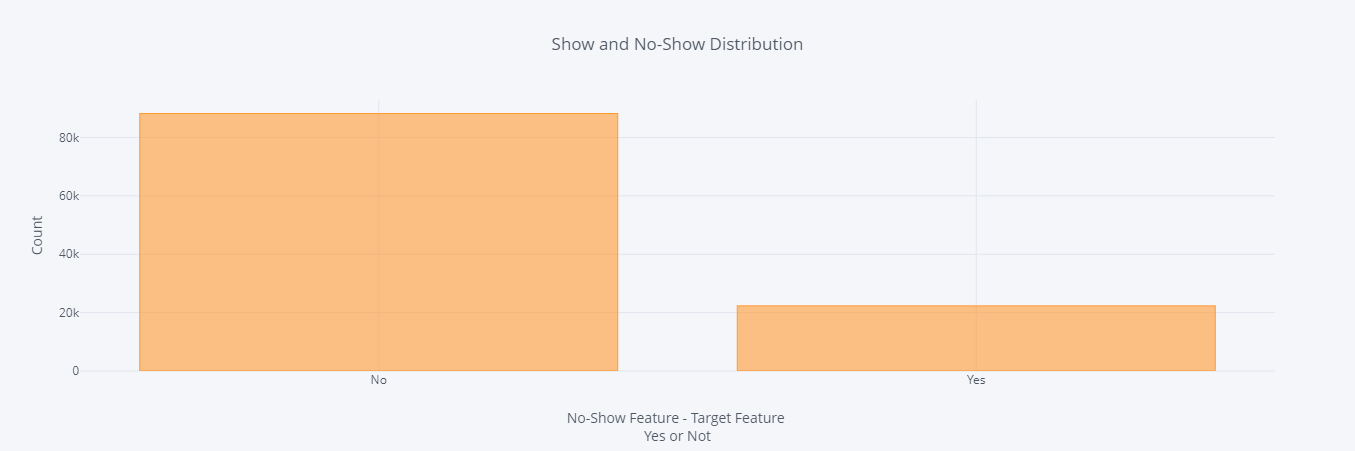

In [10]:
plotly_plots(df_train, 'No-show', title='Show and No-Show Distribution',
             xTitle='No-Show Feature - Target Feature <br>Yes or Not', 
             yTitle='Count')

Nice. We can see that we have a high ratio of No-Show patients. It will be very useful to better understand the dataset.<br>
I will explore the other variables and try to understand the relation between independents and the dependent features

## Age features

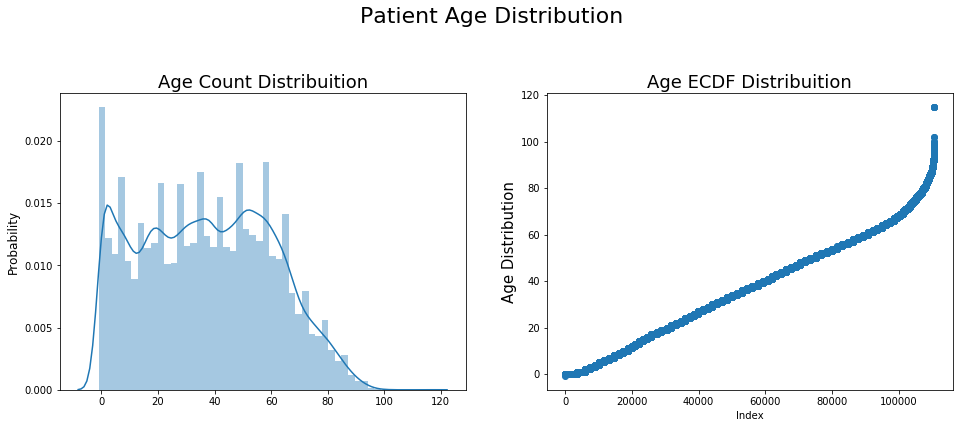

In [11]:
plt.figure(figsize=(16,12))

plt.subplot(221)
g = sns.distplot(df_train['Age'])
g.set_title("Age Count Distribuition", fontsize=18)
g.set_xlabel("")
g.set_ylabel("Probability", fontsize=12)

plt.subplot(222)
g1 = plt.scatter(range(df_train.shape[0]), np.sort(df_train.Age.values))
g1= plt.title("Age ECDF Distribuition", fontsize=18)
g1 = plt.xlabel("Index")
g1 = plt.ylabel("Age Distribution", fontsize=15)

plt.suptitle('Patient Age Distribution', fontsize=22)

plt.show()

In [12]:
print(f"The min Age in our data is {df_train.Age.min()} and the max Age is {df_train.Age.max()}")
print(f"Total of Patients with 0 years: {len(df_train[df_train.Age == 0])}")

The min Age in our data is -1 and the max Age is 115
Total of Patients with 0 years: 3539


In [13]:
quantiles(df_train, ['Age'])

Age quantiles
0.01     0.0
0.25    18.0
0.50    37.0
0.75    55.0
0.99    86.0
Name: Age, dtype: float64



Considering the percentiles I will consider only the Ages between 0 to 100 and set the Age to categories to better analize it

In [14]:
df_train = df_train[(df_train.Age >= 0 ) & (df_train.Age <= 100)]
print(f"Shape after filtering Data: {df_train.shape}")

Shape after filtering Data: (110519, 24)


- Cool, we have droped almost 50 rows. <br>
Now, let's create the age bins

## Seting ages to categories
- I will use the pd.cut function to binarize our data and create categories to Ages

In [15]:
bin_ranges = [-1, 2, 8, 16, 18, 25, 40, 50, 60, 75]
bin_names = ["Baby", "Children", "Teenager", 'Young', 'Young-Adult', 'Adult', 'Adult-II', 'Senior', 'Old']

df_train['age_bin'] = pd.cut(np.array(df_train['Age']),
                               bins=bin_ranges, labels=bin_names)

## Age Bins by No-show (target) feature

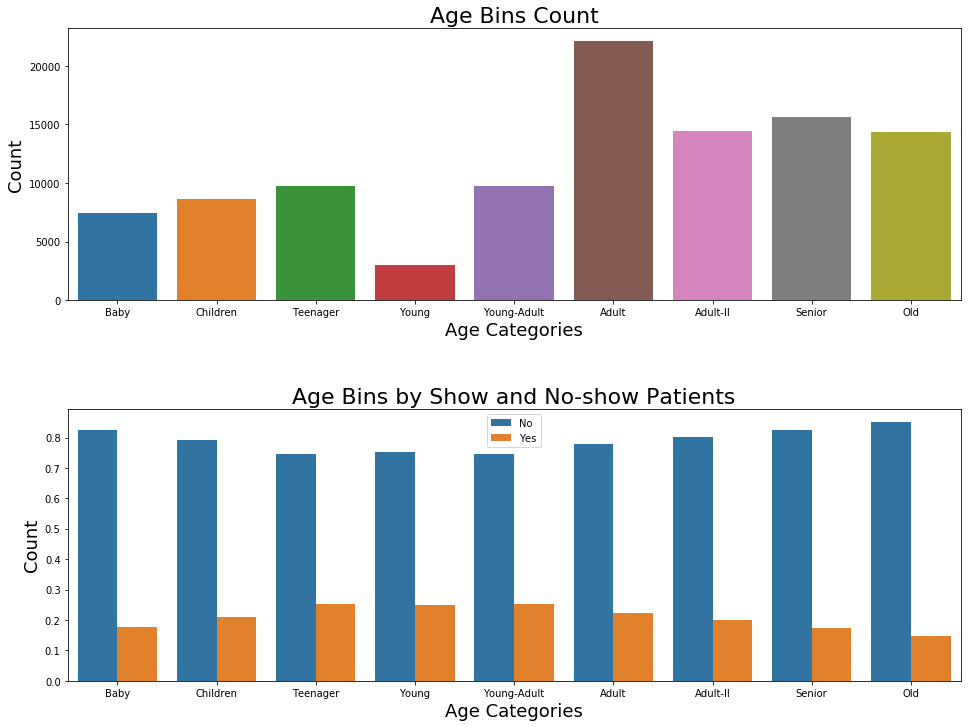

In [16]:
# now stack and reset
show_prob_age = pd.crosstab(df_train['age_bin'], df_train['No-show'], normalize='index')
stacked = show_prob_age.unstack().reset_index().rename(columns={0:'value'})

plt.figure(figsize=(16,12))
plt.subplot(211)
ax1 = sns.countplot(x="age_bin", data=df_train)
ax1.set_title("Age Bins Count", fontsize=22)
ax1.set_xlabel("Age Categories", fontsize=18)
ax1.set_ylabel("Count", fontsize=18)

plt.subplot(212)
ax2 = sns.barplot(x=stacked.age_bin, y=stacked.value, hue=stacked['No-show'])
ax2.set_title("Age Bins by Show and No-show Patients", fontsize=22)
ax2.set_xlabel("Age Categories", fontsize=18)
ax2.set_ylabel("Count", fontsize=18)
ax2.legend(loc='out')

plt.subplots_adjust(hspace = 0.4)

plt.show()

We can't see a great difference between the categories, altough the we can see that teenager to young-adult has a slightly higher ratio 25% of no-show, against the 22 to 14% of another categories. <br>
The lower ratios of no-show Patients are the old people and Babys. That make a lot of sense.<br>
I will explore it further and try to cross this Age categories by some Binary features to see if we can get some insights about the no-show Patients;

## Knowing our binary features

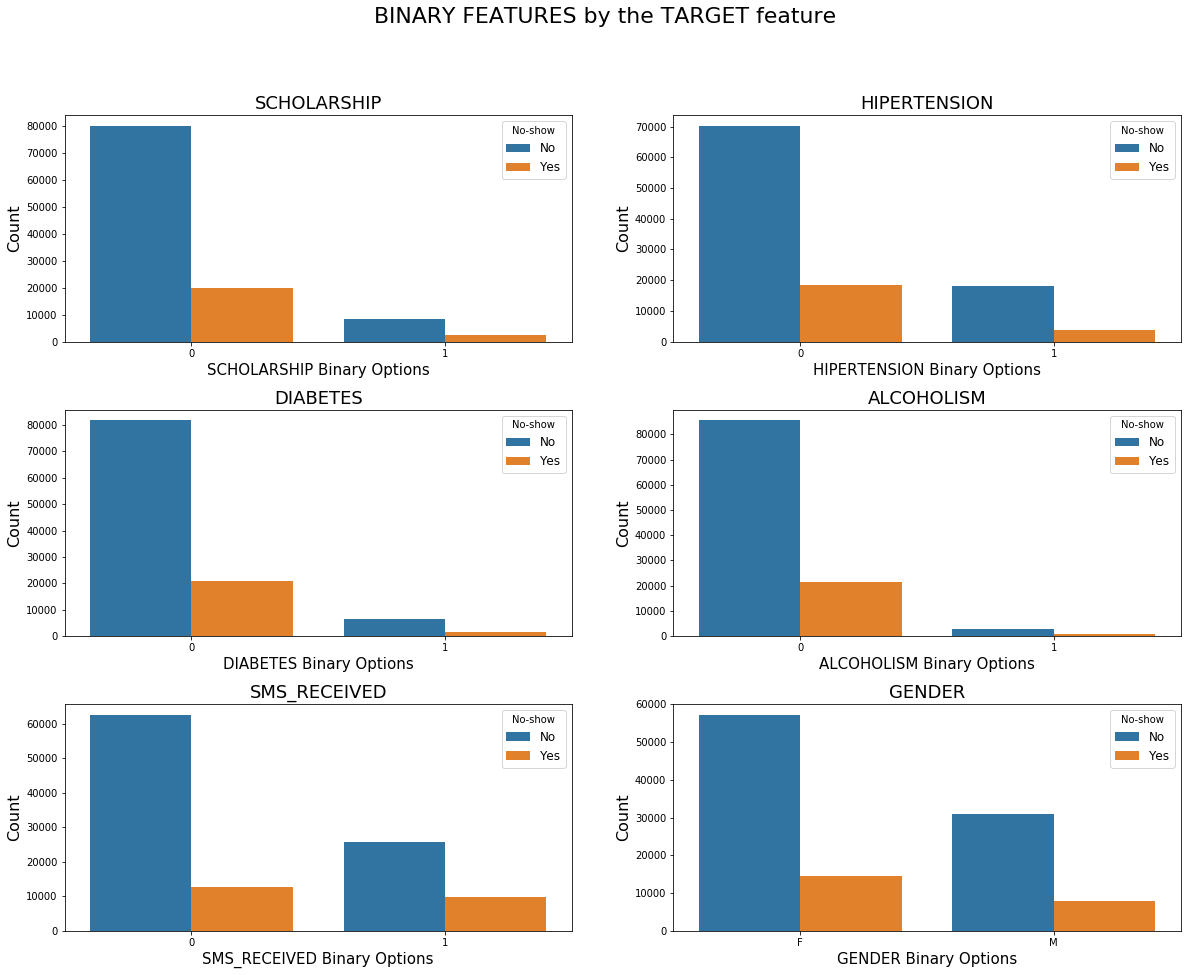

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,15))
fig.subplots_adjust(hspace=0.3)
fig.suptitle('BINARY FEATURES by the TARGET feature', fontsize=22)

for ax, catplot in zip(axes.flatten(), df_train[binary_features].columns):
    sns.countplot(x=catplot, data=df_train, hue='No-show', ax=ax)
    ax.set_title(catplot.upper(), fontsize=18)
    ax.set_ylabel('Count', fontsize=16)
    ax.set_xlabel(f'{catplot.upper()} Binary Options', fontsize=15)
    ax.legend(title='No-show', fontsize=12, )

Interesting patterns... We can see that almost all binary's features has the same ratio in the True and False groups. <br>
In the SMS_Received we can see that the ratio of the True group is very different of the False Group. <br>
As

## Exploring SMS_received

In [18]:
sms_received = df_train.groupby([df_train['AppointmentDay'].dt.date,
                                 "SMS_received", "No-show"])['PatientId'].count().reset_index().rename(columns={'PatientId': "Total"})

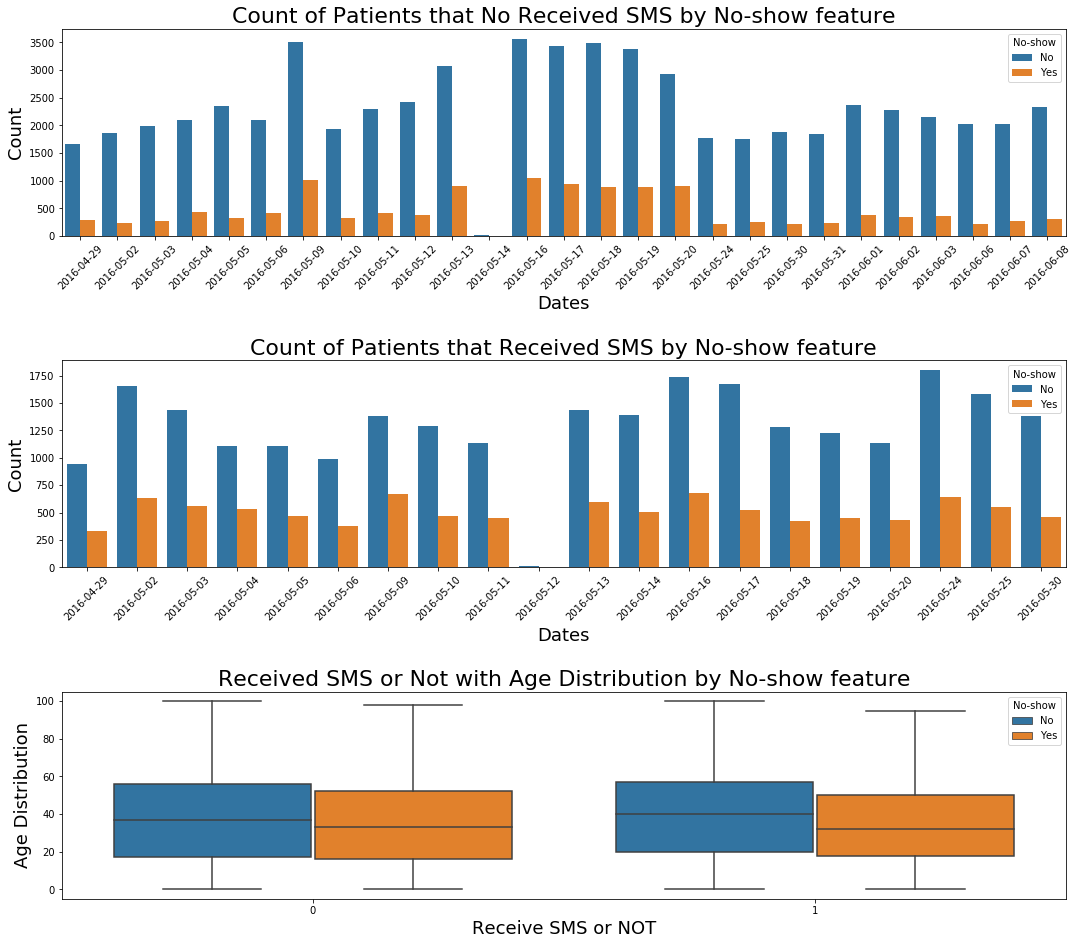

In [19]:

plt.figure(figsize=(18,16))

plt.subplot(3,1,1)
g = sns.barplot(x='AppointmentDay', y= 'Total', hue='No-show', data=sms_received[sms_received['SMS_received'] == 0])
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Count of Patients that No Received SMS by No-show feature", fontsize=22)
g.set_xlabel("Dates", fontsize=18)
g.set_ylabel("Count", fontsize=18)

plt.subplot(3,1,2)
g1 = sns.barplot(x='AppointmentDay', y= 'Total', hue='No-show', data=sms_received[sms_received['SMS_received'] == 1])
g1.set_xticklabels(g.get_xticklabels(),rotation=45)
g1.set_title("Count of Patients that Received SMS by No-show feature", fontsize=22)
g1.set_xlabel("Dates", fontsize=18)
g1.set_ylabel("Count", fontsize=18)

plt.subplot(3,1,3)
g2 = sns.boxplot(x='SMS_received', y= 'Age', hue='No-show', data=df_train)
g2.set_xticklabels(g2.get_xticklabels(),rotation=0)
g2.set_title("Received SMS or Not with Age Distribution by No-show feature", fontsize=22)
g2.set_xlabel("Receive SMS or NOT", fontsize=18)
g2.set_ylabel("Age Distribution", fontsize=18)

plt.subplots_adjust(hspace = 0.6)

plt.show()

Cool!!! My hypothesis is that the many people that received SMS could be to reschedule or cancel the appointment.  <br>
Also, we can see that people that no-show in appointments has a slightly different Age mean, that is what we saw in the other chart;

I will explore the binary features below.

## Neighbourhood No-show by Age distribution
- Now we will see the distributions of Age for each Neighbourhood by No-show feature
- The Neighbourhood with less than 100 entries I will se to "Others"

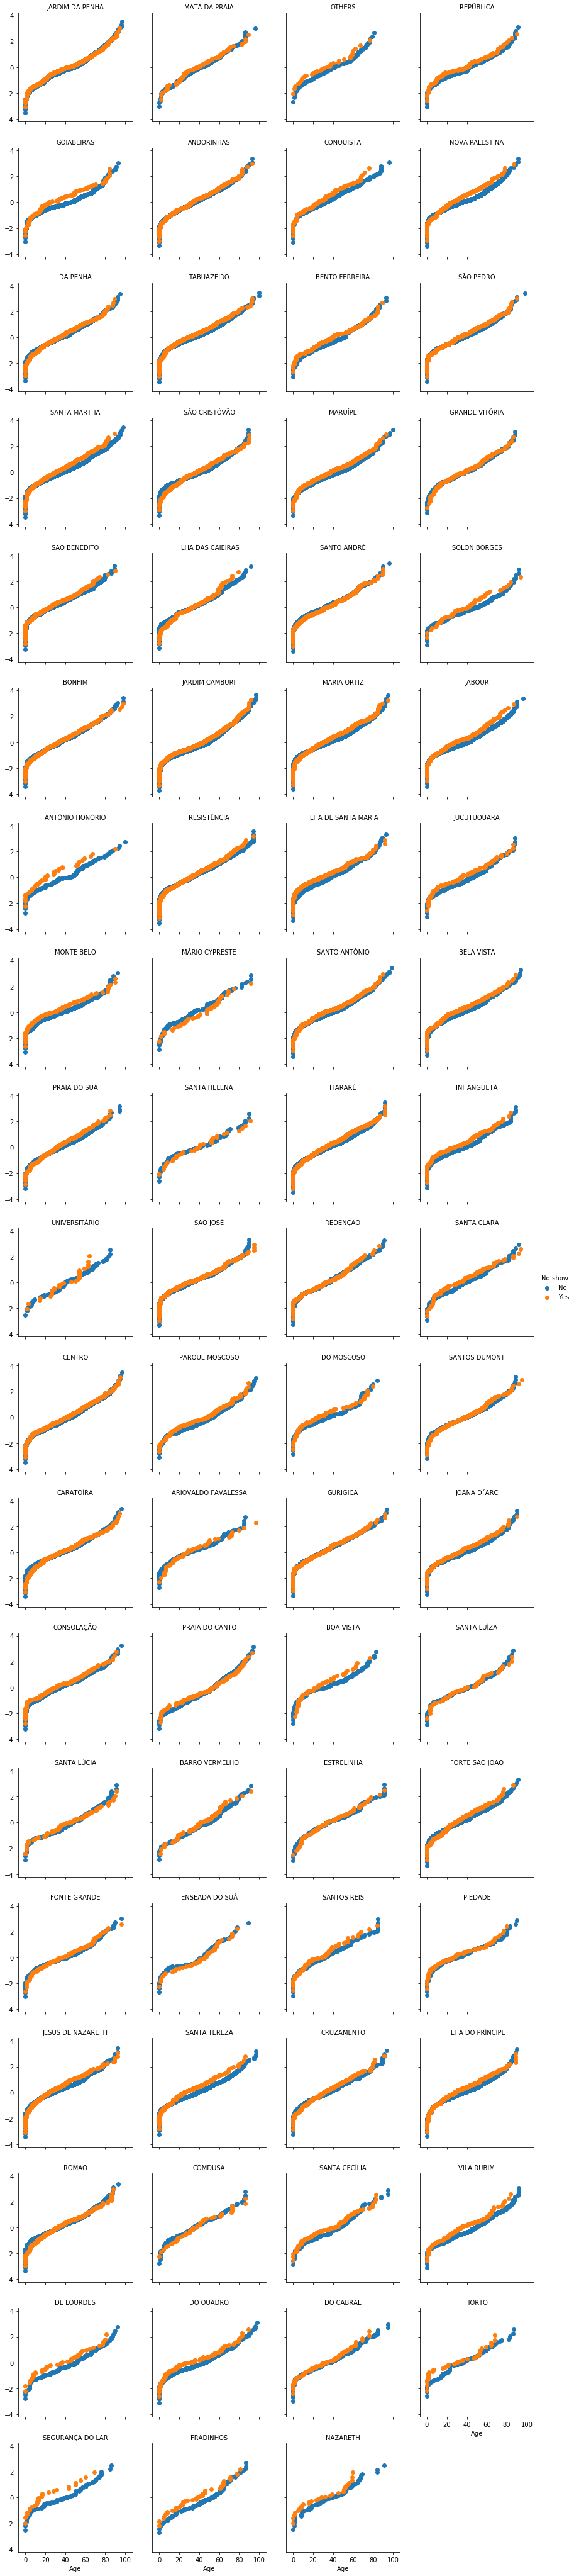

In [20]:
less_than_100 = ['MORADA DE CAMBURI', 'PONTAL DE CAMBURI', 'ILHA DO BOI', 'ILHA DO FRADE', 
                 'AEROPORTO', 'ILHAS OCEÂNICAS DE TRINDADE', 'PARQUE INDUSTRIAL']

df_train.loc[df_train.Neighbourhood.isin(less_than_100), 'Neighbourhood'] = "OTHERS"

g = sns.FacetGrid(df_train, col="Neighbourhood", 
                  col_wrap=4, height=3, 
                  hue='No-show')

g.map(quantile_plot, "Age").add_legend();
g.set_titles('{col_name}')
plt.show()

- Nice! Apparently the Neighbourhood don't have some influence in Appointments No-show.

## Date Columns
- Cleaning
- Extracting time features
- Counting Appointments by date
- Date Distribution

In [21]:
## Creating a feature that is the difference between the schedule and the appointment 
df_train['waiting_days'] = (df_train['AppointmentDay'] - df_train['ScheduledDay']).dt.days

In [22]:
print(quantiles(df_train, ['waiting_days']))

waiting_days quantiles
0.01    -1.0
0.25    -1.0
0.50     3.0
0.75    14.0
0.99    67.0
Name: waiting_days, dtype: float64

None


Interesting values. It shows that we have many values in -1... We will explore it further later and maybe filter the data that are outliers or any typo.

## Range of Dates and the differences between Scheduled and Appointment dates

In [23]:
Schedules = (df_train['ScheduledDay'].dt.date.max() - df_train['ScheduledDay'].dt.date.min()).days
Appointments = (df_train['AppointmentDay'].dt.date.max() - df_train['AppointmentDay'].dt.date.min()).days
diff_days = df_train['waiting_days'].max() - df_train['waiting_days'].min() 

print(f"Total date window of SCHEDULES is {Schedules} days. \n\
        Min date: {df_train['ScheduledDay'].dt.date.min()} \n\
        Max date: {df_train['ScheduledDay'].dt.date.max()} \n")
print("#"*50, "\n")
print(f"Total date window of APPOINTMENTS is {Appointments} days. \n\
        Min date: {df_train['AppointmentDay'].dt.date.min()} \n\
        Max date: {df_train['AppointmentDay'].dt.date.max()}")
print("#"*50, "\n")
print(f"Total date window of APPOINTMENTS is {diff_days} days. \n\
        Min date: {df_train['waiting_days'].min()} \n\
        Max date: {df_train['waiting_days'].max()}")

Total date window of SCHEDULES is 211 days. 
        Min date: 2015-11-10 
        Max date: 2016-06-08 

################################################## 

Total date window of APPOINTMENTS is 40 days. 
        Min date: 2016-04-29 
        Max date: 2016-06-08
################################################## 

Total date window of APPOINTMENTS is 185 days. 
        Min date: -7 
        Max date: 178


Cool. I will explore the date columns and try get some insight about the No-show patterns <br>
<br>
Based on the quantiles and the range of days to the appointment, I will filter the data and get the range -1 to 100.

I think that -1 don't make any sense, but I think that it could be emergence appointments and zero is when the Patient Schedule in the same day.

## Ploting the waiting days by percent of Show and No-show Patients
- As the 99 quantile of our data is 65, I will consider the data between -1 to 70 and show the ratio of the target to each schedule time difference

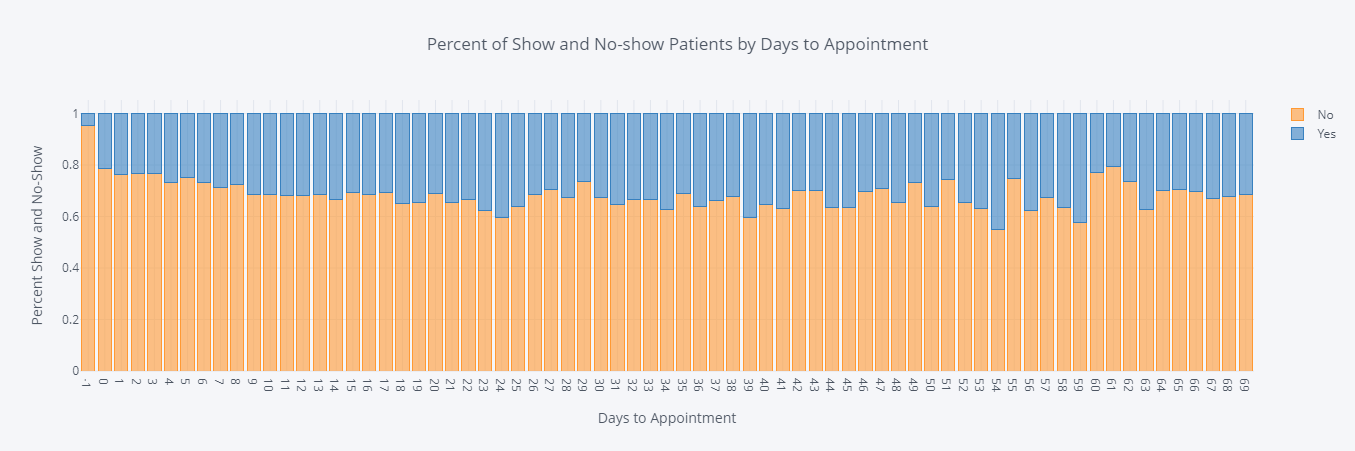

In [24]:
group_temp = df_train[(df_train['waiting_days'] < 70) &
                      (df_train['waiting_days'] >= -1)].groupby(['waiting_days', 'No-show'])['PatientId'].count() \
                        / df_train[(df_train['waiting_days'] < 70) & 
                                   (df_train['waiting_days'] >= -1)].groupby(['waiting_days'])['PatientId'].count() 

# plt.figure(figsize=(14,6))

# sns.countplot(x='waiting_days', hue='No-show', data=df_train[(df_train['waiting_days'] < 10) & (df_train['waiting_days'] >= -1)]) 
fig = group_temp.unstack().iplot(kind='bar', barmode='stack', asFigure=True,
                           title='Percent of Show and No-show Patients by Days to Appointment',
                           xTitle='Days to Appointment', yTitle='Percent Show and No-Show')

fig.layout.xaxis.type = 'category'
iplot(fig)

I Think that -1 could be emergence.

## Filtering and replacing the data 
- Getting the values with range difference into -1 to 100

In [25]:
df_train = df_train[(df_train['waiting_days'] >= -1) & (df_train['waiting_days'] <=100)]

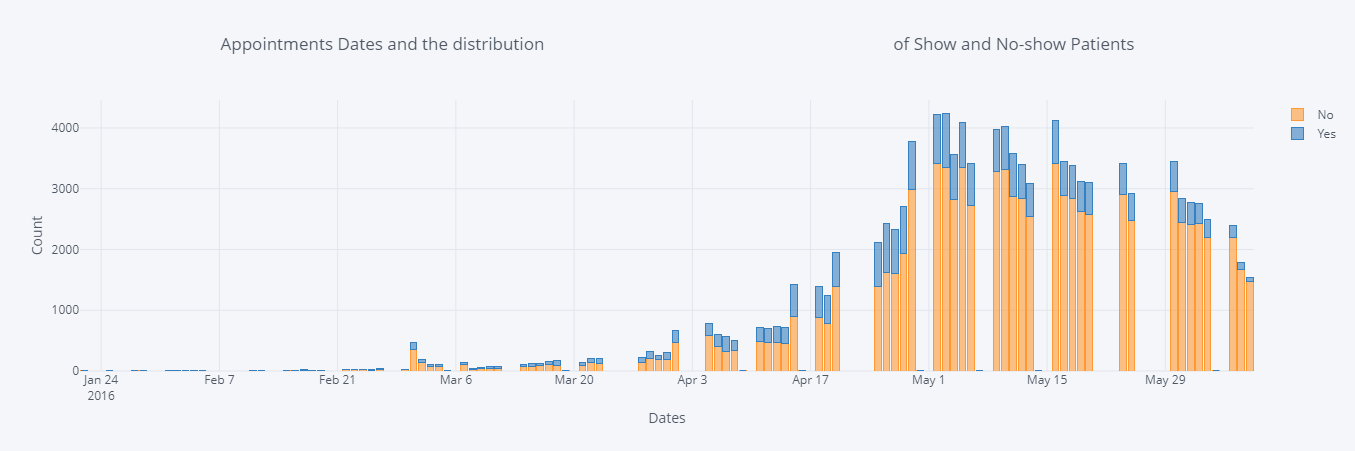

In [26]:
df_train.groupby([df_train.ScheduledDay.dt.date, 
                  'No-show' ])['PatientId'].count().unstack().fillna(0).iplot(kind='bar', 
                                                                              barmode='stack',
                                                                              title='Appointments Dates and the distribution \
                                                                              of Show and No-show Patients',
                                                                              xTitle='Dates',
                                                                              yTitle='Count '
                                                                             )

Maybe will be interesting to get the data highest than march 2016

In fact, the distribution is

many_appointments_patients = df_train.groupby(['PatientId'])['AppointmentID'].count().sort_values(ascending=False).head(10)
df_train[df_train.PatientId.isin(many_appointments_patients.index)]['No-show'].value_counts(normalize=True).plot(kind='bar')

# Start Modelling
## Preprocessing

In [27]:
df_train.Gender = df_train['Gender'].map({"F":0, "M":1})
df_train['No-show'] = df_train['No-show'].map({"No":0, "Yes":1})
df_train = dummies(df_train, categorical)

df_train.drop(['_weekdayName_AppointmentDay', 'AppointmentID', 'PatientId', 'age_bin',
                         'ScheduledDay', 'AppointmentDay', '_weekdayName_AppointmentDay',
                         '_weekdayName_ScheduledDay'], axis=1, inplace=True)

In [28]:
df_train.astype(float).corr()['No-show'].sort_values(ascending=False).head(10)

No-show                            1.000000
waiting_days                       0.192892
SMS_received                       0.126427
_hour_ScheduledDay                 0.060500
_day_ScheduledDay                  0.046674
Scholarship                        0.029243
Neighbourhood_ITARARÉ              0.027518
Neighbourhood_SANTOS DUMONT        0.023610
Neighbourhood_JESUS DE NAZARETH    0.017188
_minute_ScheduledDay               0.014939
Name: No-show, dtype: float64

## Correlation matrix of all features

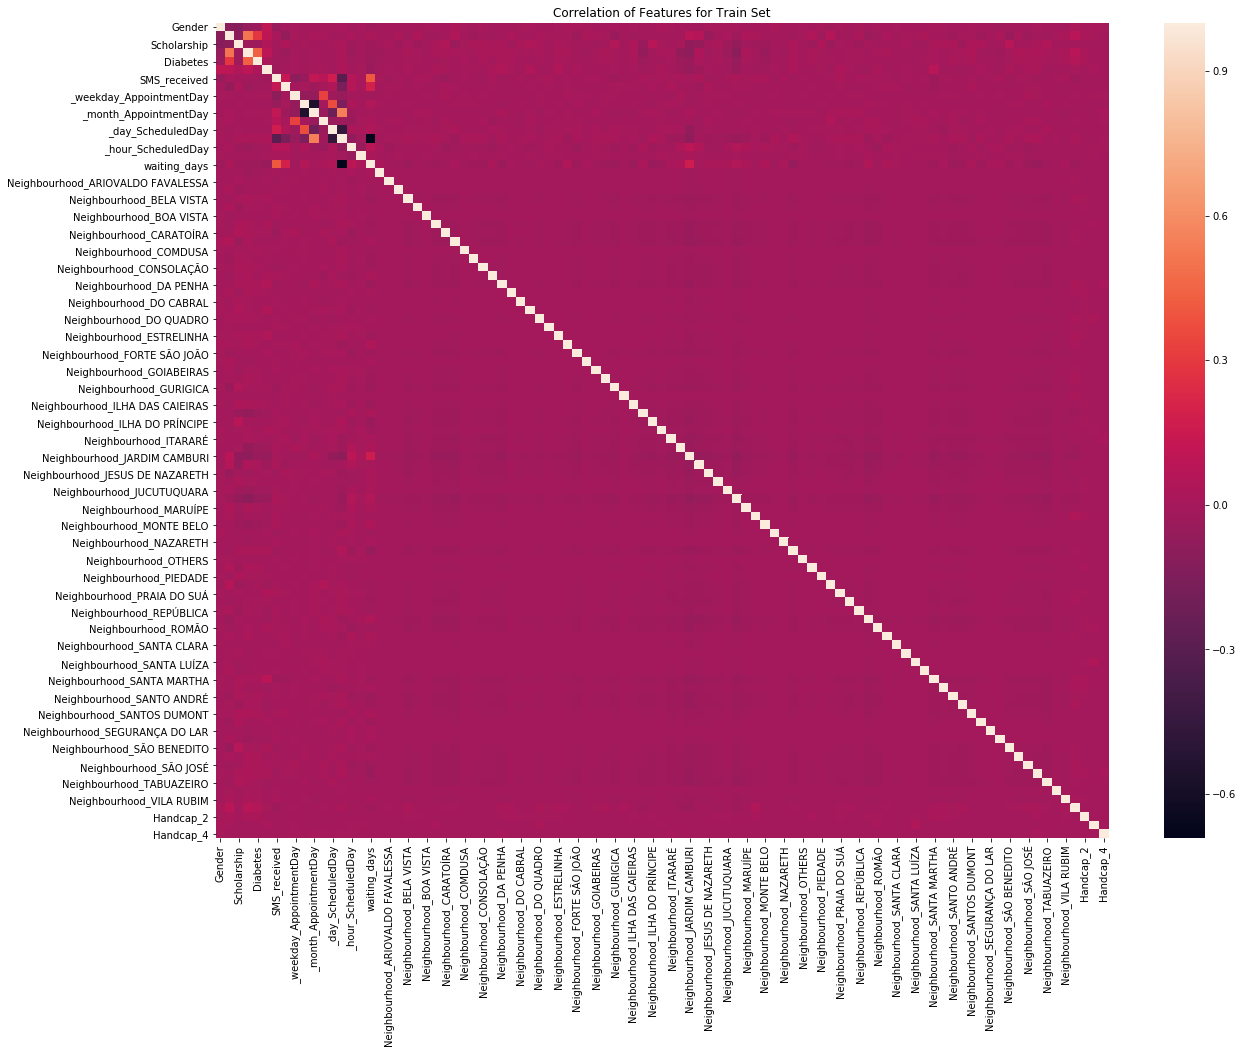

In [29]:
#Finallt, lets look the correlation of df_train
plt.figure(figsize=(20,15))
plt.title('Correlation of Features for Train Set')
sns.heatmap(df_train.astype(float).corr(), vmax=1.0 )
plt.show()

## Seting X and y to train the model and spliting into validation set

In [30]:
y_train = df_train['No-show']
X_train = df_train.drop('No-show', axis=1)

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25)

In [32]:
#Importing the auxiliar and preprocessing librarys 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import accuracy_score

#Models
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, RandomTreesEmbedding

## Pipelining the models and ploting the cross validation results

LogReg: 0.794049 (+/- 0.002856)
XGBClassifier: 0.797987 (+/- 0.003105)
KNN: 0.777041 (+/- 0.004062)
DecisionTreeClassifier: 0.730702 (+/- 0.004391)
RandomForestClassifier: 0.796224 (+/- 0.004331)
GradientBoostingClassifier: 0.799026 (+/- 0.003193)
RidgeClassifier: 0.795849 (+/- 0.003016)
BaggingRidgeClassifier: 0.792974 (+/- 0.004909)
ExtraTreesClassifier: 0.791984 (+/- 0.003555)


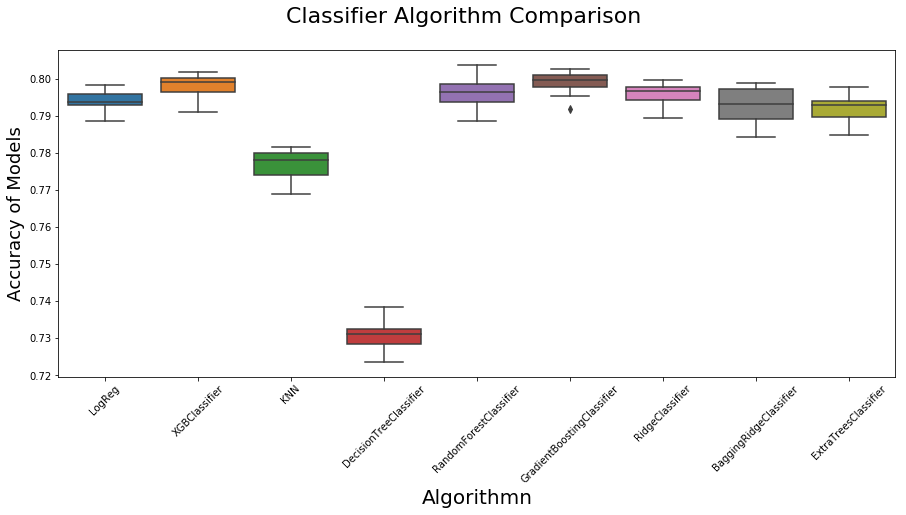

In [33]:
clfs = []
seed = 3

clfs.append(("LogReg", 
             Pipeline([("Scaler", StandardScaler()),
                       ("LogReg", LogisticRegression())])))

clfs.append(("XGBClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("XGB", XGBClassifier())]))) 
clfs.append(("KNN", 
             Pipeline([("Scaler", StandardScaler()),
                       ("KNN", KNeighborsClassifier())]))) 

clfs.append(("DecisionTreeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("DecisionTrees", DecisionTreeClassifier())]))) 

clfs.append(("RandomForestClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RandomForest", RandomForestClassifier())]))) 

clfs.append(("GradientBoostingClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("GradientBoosting", GradientBoostingClassifier(max_features=15, 
                                                                       n_estimators=600))]))) 

clfs.append(("RidgeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RidgeClassifier", RidgeClassifier())])))

clfs.append(("BaggingRidgeClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("BaggingClassifier", BaggingClassifier())])))

clfs.append(("ExtraTreesClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("ExtraTrees", ExtraTreesClassifier())])))

#'neg_mean_absolute_error', 'neg_mean_squared_error','r2'
scoring = 'accuracy'
n_folds = 10

results, names  = [], [] 

for name, model  in clfs:
    kfold = KFold(n_splits=n_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, 
                                 cv=kfold, scoring=scoring, n_jobs=-1)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  
                               cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,6))
fig.suptitle('Classifier Algorithm Comparison', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(x=names, y=results)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithmn", fontsize=20)
ax.set_ylabel("Accuracy of Models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

- We can see that just KNN and DecisionTrees hasn't 79%+ of score... <br>
- I think that 79% of accuracy using the 10 kfold is an excellent baseline.

## Getting the model optimization of XGBclassifier to predict No-show Patients
- Now we will use the hyperopt model optimization to automatize our search and get the optimal parameters

In [34]:
import scipy as sp 
from sklearn.model_selection import RandomizedSearchCV
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial
from sklearn.metrics import confusion_matrix

In [35]:
from sklearn.model_selection import StratifiedKFold

def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'gamma': "{:.3f}".format(params['gamma']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }
    
    clf = XGBClassifier(
        n_estimators=600,
        n_jobs=-1,
        **params
    )

    score = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=StratifiedKFold()).mean()
    print("Accuracy {:.8f} params {}".format(-score, params))
    return -score

space = {
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.4),
    'reg_lambda': hp.uniform('reg_lambda', 0.7, 1.0),
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

Accuracy -0.79430307 params {'max_depth': 8, 'gamma': '0.486', 'reg_alpha': '0.227', 'learning_rate': '0.136', 'colsample_bytree': '0.715'}
Accuracy -0.80083834 params {'max_depth': 6, 'gamma': '0.202', 'reg_alpha': '0.146', 'learning_rate': '0.063', 'colsample_bytree': '0.522'}
Accuracy -0.79915919 params {'max_depth': 5, 'gamma': '0.457', 'reg_alpha': '0.297', 'learning_rate': '0.154', 'colsample_bytree': '0.340'}
Accuracy -0.79924379 params {'max_depth': 4, 'gamma': '0.197', 'reg_alpha': '0.173', 'learning_rate': '0.163', 'colsample_bytree': '0.524'}
Accuracy -0.80012562 params {'max_depth': 4, 'gamma': '0.250', 'reg_alpha': '0.304', 'learning_rate': '0.054', 'colsample_bytree': '0.540'}
Accuracy -0.79064280 params {'max_depth': 8, 'gamma': '0.195', 'reg_alpha': '0.051', 'learning_rate': '0.186', 'colsample_bytree': '0.899'}
Accuracy -0.80041554 params {'max_depth': 4, 'gamma': '0.016', 'reg_alpha': '0.151', 'learning_rate': '0.101', 'colsample_bytree': '0.441'}
Accuracy -0.79128308

In [36]:
best['max_depth'] = int(best['max_depth'])

print("BEST PARAMS: ", best)

BEST PARAMS:  {'colsample_bytree': 0.5916351283209161, 'gamma': 0.2900801291249297, 'learning_rate': 0.05018074109177415, 'max_depth': 7, 'reg_alpha': 0.38355494354477654, 'reg_lambda': 0.9020867993172011}


## Predicting No-show Patients with the best parameters we found in hyperopt

In [37]:
clf = XGBClassifier(
    n_estimators=5000,
    n_jobs=-1,
    **best
)

In [38]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5916351283209161, gamma=0.2900801291249297,
       learning_rate=0.05018074109177415, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=5000, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.38355494354477654, reg_lambda=0.9020867993172011,
       scale_pos_weight=1, seed=None, silent=True, subsample=1)

In [39]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score

pred = clf.predict(X_val)

In [40]:
print(f'Accuracy of our Classifier with best Hyper Parameeters: {round(accuracy_score(y_val, pred, normalize=True),4)}')

Accuracy of our Classifier with best Hyper Parameeters: 0.8004


Confusion matrix, without normalization: 
[[20762  1301]
 [ 4206  1326]]
Normalized confusion matrix: 
[[0.94 0.06]
 [0.76 0.24]]


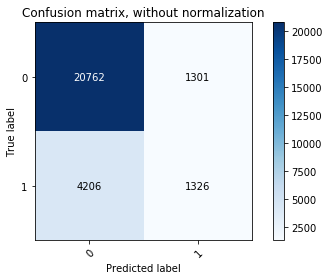

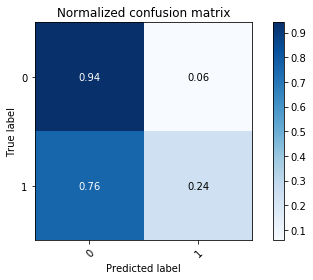

In [41]:
class_names = df_train['No-show'].unique()

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix: ")
    else:
        print('Confusion matrix, without normalization: ')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_val, pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_val, pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
# creating a model
model = RandomForestClassifier()

# feeding the training set into the model
model.fit(x_resampled, y_resampled)

# predicting the test set results
y_pred = model.predict(X_test)

# Calculating the accuracies
print("Training accuracy :", model.score(x_resampled, y_resampled))
print("Testing accuarcy :", model.score(X_test, y_test))

# classification report
cr = classification_report(y_test, y_pred)
print(cr)

# confusion matrix 
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
se.heatmap(cm, annot = True, cmap = 'winter')
plt.title('Confusion Matrix', fontsize = 20)
plt.show()

Experimenting with ANNs

In [1]:
model = Sequential()
model.add(Dense(64,input_dim = 18,activation='relu'))
model.add(Dense(32,activation='relu',init = 'uniform'))
model.add(Dense(16,activation='relu',init = 'uniform'))
model.add(Dense(1,activation = 'sigmoid'))
model.summary()

NameError: name 'Sequential' is not defined

In [ ]:
model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
history=model.fit(x_resampled,y_resampled ,epochs=50,batch_size=128, validation_data=(X_test,y_test))

In [ ]:
# evaluate the keras model
_, accuracy = model.evaluate(x_resampled, y_resampled)
print('Accuracy: %.2f' % (accuracy*100))

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()